In [11]:
from getpass import getpass

admin_rdm_url = 'http://localhost:8001/'
idp_name_1 = 'FakeCAS'
idp_username_1 = None
idp_password_1 = None
default_result_path = None
close_on_fail = False
transition_timeout = 10000

In [12]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

(30, 13)

# 定期監視-管理者-ログイン

- サブシステム名: 管理者
- ページ/アドオン: 管理者
- 機能分類: ログイン
- シナリオ名: ログイン確認
- 用意するテストデータ: URL一覧、アカウント(管理者ユーザー1: GRDM)
- 備考: https://bitbucket.org/osf_japan/operations/src/master/ARI/%E9%81%8B%E7%94%A8%E6%89%8B%E9%A0%86%E6%9B%B8/%E7%9B%A3%E8%A6%96/%E8%BF%BD%E5%8A%A0%E7%9B%A3%E8%A6%96_%E7%AE%A1%E7%90%86%E8%80%85%E7%94%BB%E9%9D%A2%E3%83%AD%E3%82%B0%E3%82%A4%E3%83%B3%E7%A2%BA%E8%AA%8D.md

## GakuNin RDM管理者ページのURLを開く

①ブラウザを開き、画面右上の設定メニューから「シークレットモードで開く」を選択する。  
②新規画面が開かれ、画面上において、「シークレットモードです」と表示されていることを確認する。
以下、シークレットモードにて確認を行う。

③ブラウザを開き、下記URLにアクセスする。  
https://rdm.example.com/  

In [13]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpou29ne9s'

In [14]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20250809-153709',
 '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmp2ly2v09y')

Start epoch: 1754721431.456175 seconds


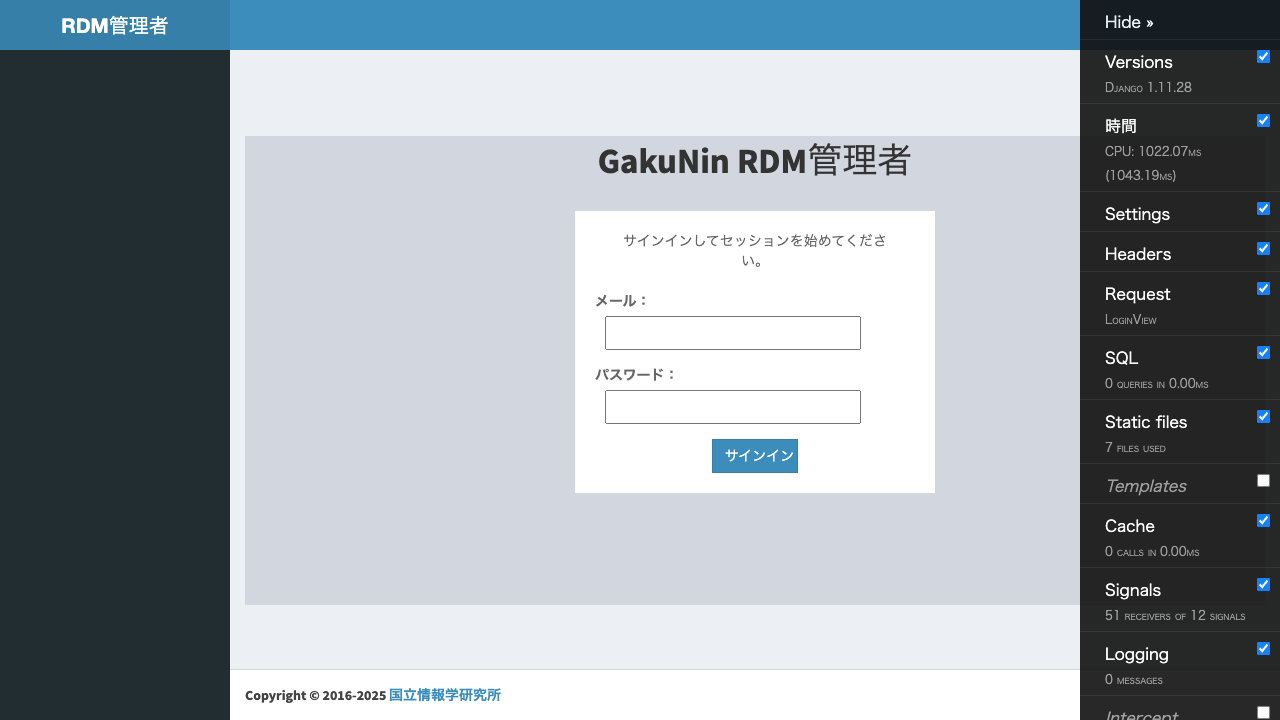

In [15]:
import time

async def _step(page):
    await page.goto(admin_rdm_url)

    await expect(page.locator('.login-logo')).to_be_visible(timeout=30000)

await run_pw(_step)

## IdPを選択する (1)

①プルダウンから、指定されたIdPを選択する。  


In [ ]:
async def _step(page):
    if idp_name_1 is None or idp_name_1 == 'FakeCAS':
        await expect(page.locator('#id_email')).to_be_editable(timeout=transition_timeout)
    else:
        # IdPリストから所望のIdPを選択
        idplist = page.locator('//form[@id = "IdPList"]//input[@type = "text"]')
        await idplist.fill(idp_name_1);
        await idplist.press('Enter');
        await page.locator(f'//div[@class = "select" and text() = "{idp_name_1}"]').click()

        # 選択ボタンが有効になったことを確認
        await expect(page.locator('//input[@id = "wayf_submit_button"]')).to_be_enabled()

await run_pw(_step)

## IdPを選択する (2)

①「選択」を押下する。  


In [ ]:
async def _step(page):
    if idp_name_1 is None or idp_name_1 == 'FakeCAS':
        return
    # 選択ボタンをクリック
    await page.locator('//input[@id = "wayf_submit_button"]').click()

    # アカウント入力欄が編集可能になったことを確認
    await expect(page.locator('#username')).to_be_editable()

await run_pw(_step)

## ログインする (1)

①「Username」と「Password」を入力する。  


In [ ]:
async def _step(page):
    # メールアドレスとパスワードを入力
    if idp_name_1 is None or idp_name_1 == 'FakeCAS':
        await page.locator('#id_email').fill(idp_username_1)
        await page.locator('#id_password').fill(idp_password_1)
    else:
        await page.locator('#username').fill(idp_username_1)
        await page.locator('#password').fill(idp_password_1)

    # サインインボタンが押下可能であることを確認
    await expect(page.locator('//button[@type = "submit"]')).to_be_enabled()

await run_pw(_step)

## ログインする (2)

①「Ask me again at next login」を押下する。  


In [ ]:
async def _step(page):
    # サインインボタンをクリック
    await page.locator('//button[@type = "submit"]').click()

    if idp_name_1 is None or idp_name_1 == 'FakeCAS':
        # メニューバーに「機関ストレージのクォータ」が表示されることを確認 - transition_timeout 秒以内に表示されることを期待
        await expect(page.locator('//*[@href="/institutional_storage_quota_control/"]')).to_be_enabled(timeout=transition_timeout)
        return
    # チェック「Ask me again at next login」が表示されることを確認 - 30秒以内に表示されることを期待
    await expect(page.locator('#_shib_idp_doNotRememberConsent')).to_be_enabled(timeout=30000)

    await page.locator('#_shib_idp_doNotRememberConsent').click()
    await expect(page.locator('#_shib_idp_doNotRememberConsent')).to_be_checked()

    # Acceptが有効
    await expect(page.locator('//*[@name="_eventId_proceed"]')).to_be_enabled()

await run_pw(_step)

## ログインする (3)

①「Accept」を押下する。  


In [ ]:
async def _step(page):
    if idp_name_1 is None or idp_name_1 == 'FakeCAS':
        return
    # サインインボタンをクリック
    await page.locator('//*[@name="_eventId_proceed"]').click()

    # メニューバーに「機関ストレージのクォータ」が表示されることを確認 - transition_timeout 秒以内に表示されることを期待
    await expect(page.locator('//*[@href="/institutional_storage_quota_control/"]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## ログアウト (1)

①「アカウント」を押下する。  


Start epoch: 1754721853.345355 seconds


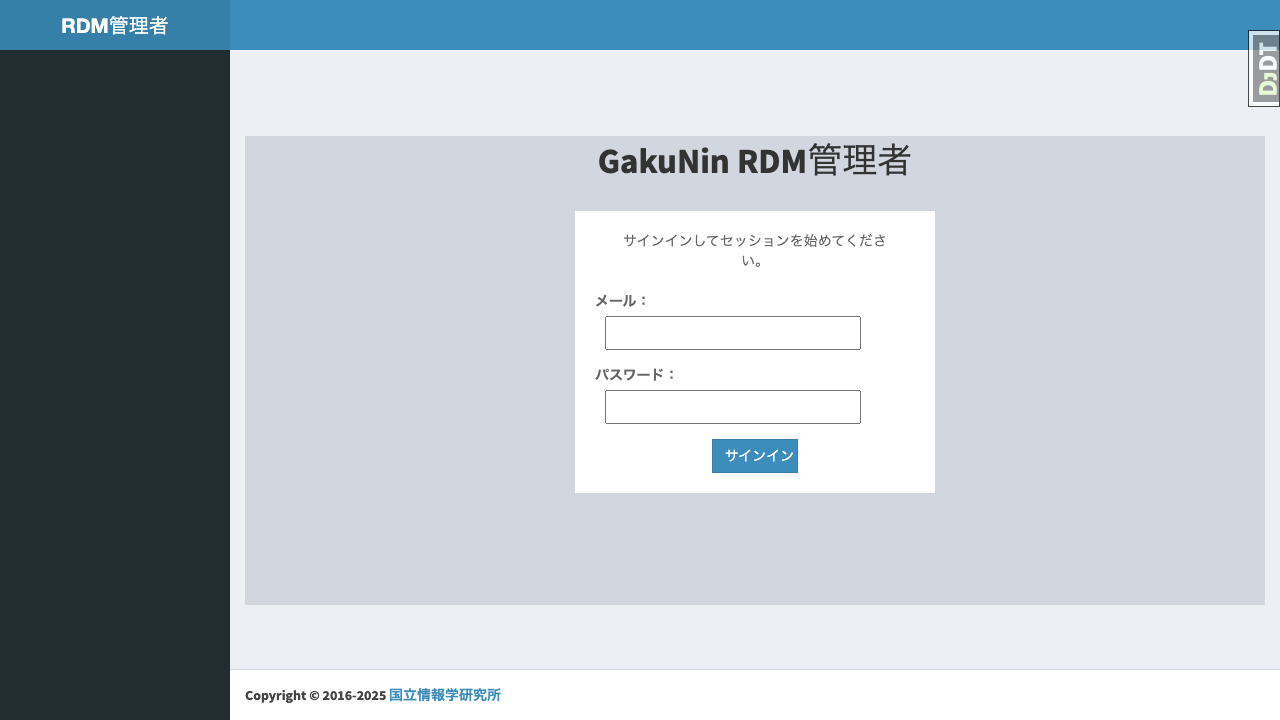

In [ ]:
import traceback

async def _step(page):
    try:
        # 念のためツールバーを隠すボタンを押しておく - なければ無視
        await page.locator('#djHideToolBarButton').click()
    except:
        print('Skipped hiding toolbar')
        traceback.print_exc()

    await page.locator('//*[@href="/account/logout/"]').click()

    await expect(page.locator('.login-logo')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

終了処理を実施。

In [15]:
await finish_pw_context()

Video: /tmp/tmpdv2cryjw/video-1.webm
HAR: /tmp/tmpdv2cryjw/har.zip


In [16]:
!rm -fr {work_dir}